In [46]:
from __future__ import annotations
import collections
import copy
import glob
import inspect
import itertools
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import sys
import tensorflow as tf
import tensorflow.keras as keras
import tqdm
from typing import Any, Callable, Iterable

In [47]:
sns.set() 

In [48]:
def split_model(
    base_model: keras.models.Model,
    cut_layer_key: int|str,
    ) -> tuple[keras.models.Model, keras.models.Model]:

    # Extract client-side input/output layers from base model.
    inp_client = base_model.input
    if isinstance(cut_layer_key, int):
        out_client = base_model.get_layer(index=cut_layer_key).output
    else:
        out_client = base_model.get_layer(name=cut_layer_key).output

    # Build client model.
    model_client = keras.models.Model(inputs=inp_client, outputs=out_client)

    # Extract server-side input/output layers.
    inp_server = keras.layers.Input(tensor=out_client) # Convert client output tensor to input layer.
    out_server = base_model.output

    # Build server model.
    model_server = keras.models.Model(inputs=inp_server, outputs=out_server)

    # Return models.
    return model_server, model_client

In [49]:
def join_model(
    model_client: keras.models.Model,
    model_server: keras.models.Model,
    ) -> keras.models.Model:

    # Get input.
    inp = model_client.input
    x = inp

    # Generate graph from client (skip input).
    for layer in model_client.layers[1:]:
        x = layer(x)

    # Add server layers to graph (skip input).
    for layer in model_server.layers[1:]:
        x = layer(x)

    # Build the base model.
    model_base = keras.models.Model(inputs=inp, outputs=x)

    # Transfer client weights.
    for layer in model_client.layers[1:]:
        model_base.get_layer(name=layer.name).set_weights(layer.get_weights())

    # Transfer server weights.
    for layer in model_server.layers[1:]:
        model_base.get_layer(name=layer.name).set_weights(layer.get_weights())

    # Return the base model.
    return model_base

In [50]:
def split_train_step(
    model_server: keras.models.Model,
    model_client: keras.models.Model,
    x: tf.Tensor,
    y: tf.Tensor,
    ) -> dict[str, tf.Tensor]:
    with tf.GradientTape(persistent=True) as tape:

        ###### Client forward pass ######
        out_client = model_client(x, training=True)

        ###### Server forward pass ######
        out_server = model_server(out_client, training=True)

        ###### Server backward pass ######
        loss = model_server.compiled_loss(
            y_true=y,
            y_pred=out_server,
            regularization_losses=model_server.losses,
        )
        # Compute server gradients.
        grad_server = tape.gradient(loss, model_server.trainable_variables)
        # Update server weights.
        model_server.optimizer.apply_gradients(zip(grad_server, model_server.trainable_variables))
        # Update server metrics.
        model_server.compiled_metrics.update_state(
            y_true=y,
            y_pred=out_server,
        )

        ###### Client backward pass ######
        grad_client = tape.gradient(loss, model_client.trainable_variables)
        # Update local client weights.
        model_client.optimizer.apply_gradients(zip(grad_client, model_client.trainable_variables))
        # No need to update client metrics since lables are on the server.

    # Return dictionary of servermetrics (including loss).
    return {m.name: m.result() for m in model_server.metrics}


In [51]:
def split_test_step(
    model_server: keras.models.Model,
    model_client: keras.models.Model,
    x: tf.Tensor,
    y: tf.Tensor,
    ) -> dict[str, tf.Tensor]:
    """Split learning validation/test step.

    Runs a single validation/test step for the given server and client models.

    Args:
        model_server (keras.models.Model): Server model (compiled with optimizer and loss).
        model_client (keras.models.Model): Client model (compiled with optimizer and loss).
        x (tf.Tensor): Batched validation/test input.
        y (tf.Tensor): Batched validation/test targets.

    Returns:
        dict[str, tf.Tensor]: Dictionary of server model metrics after the current validation/test step.
    """

    ###### Client forward pass ######
    out_client = model_client(x, training=False)

    ###### Server forward pass ######
    out_server = model_server(out_client, training=False)
    # Update server metrics.
    model_server.compiled_metrics.update_state(
        y_true=y,
        y_pred=out_server,
    )

    # Return dictionary of servermetrics (including loss).
    return {f"val_{m.name}": m.result() for m in model_server.metrics}

In [52]:
def fed_avg(
    model_weights: dict[str, list[tf.Tensor]],
    dist: dict[str, float],
    ) -> list[tf.Tensor]:
    """Weighted average of model layer parameters.

    Args:
        model_weights (dict[str, list[tf.Tensor]]): Dictionary of model weight lists.
        dist (dict[str, float]): Distribution for weighted averaging.

    Returns:
        list[tf.Tensor]: List of averaged weight tensors for each layer of the model.
    """

    # Scale the weights using the given distribution.
    model_weights_scaled = [
        [dist[key] * layer for layer in weights] 
        for key, weights in model_weights.items()
    ]

    # Average the weights.
    avg_weights = []
    for weight_tup in zip(*model_weights_scaled):
        avg_weights.append(
            tf.math.reduce_sum(weight_tup, axis=0)
        )
    return avg_weights

In [53]:
# # FedAvgM
# def server_aggregate_M(global_model, client_models, client_lens):
#     total = sum(client_lens)    # 592    sum [51, 122, 162, 257]
#     n = len(client_models)      # 4 local clients
#     global_dict = global_model.state_dict() # weight/bias dict --> {'encoder.0.weight': Tensor with shape torch.Size([86, 115]), 'encoder.0.bias':....} 16 items
#     temp = copy.deepcopy(global_dict)       # temporary weight/bias dict
#     v = {x:1 for x in copy.deepcopy(global_dict)}   # initialise v

#     for i,k in enumerate(global_dict.keys()): 
#         # calculate average weight/bias --> avg_w/b
#         temp[k] = torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
#         temp_v = 0.9 * v[k] + temp[k]               # v = 0.9v + avg_w/b   momentum=0.9
#         global_dict[k] = global_dict[k] - temp_v    # w = w - v
#     global_model.load_state_dict(global_dict)

#     for model in client_models:
#         model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias

In [54]:
# Inspired by: https://docs.python.org/3/library/itertools.html#itertools-recipes
def grouper(iterable: Iterable[Any], n: int, fillvalue: Any = None) -> Iterable[Any]:
    """Collects input into non-overlapping fixed-length chunks.

    Args:
        iterable (Iterable[Any]): Input sequence.
        n (int): Number of elements per chunk.
        fillvalue (Any, optional): Value to fill if last chunk has missing elements. Defaults to `None`.

    Returns:
        Iterable[Any]: Sequence of grouped elements.
    """
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

# Type alias the training history.
TrainHistory = dict[str, dict[str, list]]


In [55]:
def train_splitfed(
    model_server: keras.models.Model,
    model_client: keras.models.Model,
    model_builder_server: Callable[[keras.models.Model], keras.models.Model],
    model_builder_client: Callable[[keras.models.Model], keras.models.Model],
    client_data: dict[int|str, tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]], 
    # Dictionary of client data, where values are tuple(train, val, test) subsets (assumes already batched). 
    #The length of the dictionary determines the number of clients.
    n_rounds: int, # Number of global communication rounds.
    n_epochs: int, # Number of local client training epochs.
    group_size: int, # Number of random clients within group.
    shuffle: bool = True, # Randomly select clients in a group.
    ) -> tuple[TrainHistory, tuple[keras.models.Model, keras.models.Model]]:
    # Maintain list of client IDs for grouping.
    client_ids = list(client_data)

    ########## Main Server ###############
    # Build initial server model.
    model_server = model_builder_server(model_server)

    # Copy of global server weight parameters.
    global_weights_server = copy.deepcopy(model_server.get_weights())
    ######################################

    ########## Federated Server ##########
    # Build initial client model.
    model_client = model_builder_client(model_client)

    # Copy of global client weight parameters.
    global_weights_client = copy.deepcopy(model_client.get_weights())
    #######################################

    # Track the training history.
    history: TrainHistory = {key: collections.defaultdict(list) for key in client_data}

    # Global training loop.
    # Communication rounds between server <--> clients.
    for round in range(n_rounds):
        
        # Shuffle the client IDs.
        if shuffle:
            np.random.shuffle(client_ids)

        # Generate groups of shuffled client IDs.
        groups = list(grouper(client_ids, n=group_size, fillvalue=None))
        n_groups = len(groups)
        for group, tup in enumerate(groups):
            # Preserve same initial server weights for each group.
            group_weights_server = copy.deepcopy(global_weights_server)

            # Perserve server weights for each client update.
            all_server_weights: dict[str, tf.Tensor] = {}

            # Train each client model.
            # This could be done in parallel, but here we do it 
            # synchronously for ease of development.
            all_client_weights: dict[str, tf.Tensor] = {}
            all_client_data_records_train: dict[str, int] = {}
            for client in filter(lambda value: value is not None, tup): # Remove any filled values.

                # Retreive data for current client.
                (train_dataset, val_dataset, test_dataset) = client_data[client]

                # Reset server model so that weights are fresh during synchronous updates.
                model_server.set_weights(group_weights_server)

                # Synchronize global client model to local client.
                model_client_local = model_builder_client(model_client)
                model_client_local.set_weights(global_weights_client)

                # Train the current model for the desired number of epochs.
                all_client_data_records_train[client] = 0 # Initialize record count.
                for epoch in range(n_epochs):

                    # Training loop.
                    with tqdm.tqdm(train_dataset, unit='batch') as pbar:
                        for step, (x_train_batch, y_train_batch) in enumerate(pbar):
                            pbar.set_description(f"[round {round+1}/{n_rounds}, group {group+1}/{n_groups}, client {client}, epoch {epoch+1}/{n_epochs}] train")

                            # Run a single training step.
                            metrics_train = split_train_step(
                                model_server=model_server,
                                model_client=model_client_local,
                                x=x_train_batch,
                                y=y_train_batch,
                            )

                            # Add current number of batches to total number of records for the current client.
                            all_client_data_records_train[client] += x_train_batch.shape[0]

                            # Update progress bar with metrics.
                            pbar.set_postfix({k:v.numpy() for k,v in metrics_train.items()})

                            # Add to history.
                            for k,v in metrics_train.items():
                                history[client][k].append(v.numpy())

                    # Validation loop.
                    with tqdm.tqdm(val_dataset, unit='batch') as pbar:
                        for x_val_batch, y_val_batch in pbar:
                            pbar.set_description(f"[round {round+1}/{n_rounds}, group {group+1}/{n_groups}, client {client}, epoch {epoch+1}/{n_epochs}] val")

                            # Run a single validation step.
                            metrics_val = split_test_step(
                                model_server=model_server,
                                model_client=model_client_local,
                                x=x_val_batch,
                                y=y_val_batch,
                            )

                            # Update progress bar with metrics.
                            pbar.set_postfix({k:v.numpy() for k,v in metrics_val.items()})

                            # Add to history.
                            for k,v in metrics_val.items():
                                history[client][k].append(v.numpy())

                    # Reset train/val metrics.
                    model_client.reset_metrics()
                    model_server.reset_metrics()

                # Create a copy of this client's model weights and preserve for future aggregation.
                all_client_weights[client] = copy.deepcopy(model_client_local.get_weights())

                # Create a copy of the server weights for the current group.
                group_weights_server = copy.deepcopy(model_server.get_weights())

                # Create a copy of the current server weights.
                all_server_weights[client] = copy.deepcopy(model_server.get_weights())

            # Count total number of data records across all clients.
            total_data_records = float(sum(v for _, v in all_client_data_records_train.items()))

            # Now perform federated averaging for weights of clients within the current group.
            # To do this, first compute distribution for weighted-average.
            # Then perform federated averaging weight aggregation.
            dist = {
                client: float(count)/total_data_records
                for client, count in all_client_data_records_train.items()
            }
            global_weights_client = fed_avg(model_weights=all_client_weights, dist=dist)

            # Also average server weights for each client update.
            global_weights_server = fed_avg(model_weights=all_server_weights, dist=dist)
        
    # Load the final global weights for the server and client.
    model_server.set_weights(global_weights_server)
    model_client.set_weights(global_weights_client)

    # Return server and client models.
    return history, (model_server, model_client)

In [56]:
benign = pd.read_csv('../BOTNET/1.benign.csv')
mirai_ack = pd.read_csv('../BOTNET/1.mirai.ack.csv')
mirai_scan = pd.read_csv('../BOTNET/1.mirai.scan.csv')
mirai_syn = pd.read_csv('../BOTNET/1.mirai.syn.csv')
mirai_udp = pd.read_csv('../BOTNET/1.mirai.udp.csv')
mirai_udp_plain = pd.read_csv('../BOTNET/1.mirai.udpplain.csv')
gafgyt_combo = pd.read_csv('../BOTNET/1.gafgyt.combo.csv')
gafgyt_junk = pd.read_csv('../BOTNET/1.gafgyt.junk.csv')
gafgyt_scan = pd.read_csv('../BOTNET/1.gafgyt.scan.csv')
gafgyt_tcp = pd.read_csv('../BOTNET/1.gafgyt.tcp.csv')
gafgyt_udp = pd.read_csv('../BOTNET/1.gafgyt.udp.csv')

In [57]:
benign = benign.sample(frac=0.50, replace=False)

mirai_ack = mirai_ack.sample(frac=0.24, replace=False)
mirai_scan = mirai_scan.sample(frac=0.22, replace=False)
mirai_syn = mirai_syn.sample(frac=0.2, replace=False)
mirai_udp = mirai_udp.sample(frac=0.1, replace=False)
mirai_udp_plain = mirai_udp_plain.sample(frac=0.3, replace=False)

gafgyt_combo = gafgyt_combo.sample(frac=0.4, replace=False)
gafgyt_junk = gafgyt_junk.sample(frac=0.8, replace=False)
gafgyt_scan = gafgyt_scan.sample(frac=0.8, replace=False)
gafgyt_tcp = gafgyt_tcp.sample(frac=0.25, replace=False)
gafgyt_udp = gafgyt_udp.sample(frac=0.23, replace=False)

In [58]:
benign['type']='benign'
mirai_ack['type']='mirai_ack'
mirai_scan['type']='mirai_scan'
mirai_syn['type'] = 'mirai_syn'
mirai_udp['type'] = 'mirai_udp'
mirai_udp_plain['type'] = 'mirai_udp_plain'

gafgyt_combo['type'] = 'gafgyt_combo'
gafgyt_junk['type'] = 'gafgyt_junk'
gafgyt_scan['type'] = 'gafgyt_scan'
gafgyt_tcp['type'] = 'gafgyt_tcp'
gafgyt_udp['type'] = 'gafgyt_udp'

In [59]:
data = pd.concat([benign, 
                  mirai_ack, mirai_scan, mirai_syn, mirai_udp, mirai_udp_plain,
                 gafgyt_combo, gafgyt_junk, gafgyt_scan, gafgyt_tcp, gafgyt_udp], 
                 axis=0, sort=False, ignore_index=True)

In [60]:
data = data.sample(frac=1).reset_index(drop=True)
data = data.iloc[:264000,:]
data

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,type
0,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,...,0.000000e+00,0.0,1.000000,60.0,0.000000,60.000000,0.000000e+00,0.000000e+00,0.000000e+00,gafgyt_tcp
1,107.930564,471.392138,3.398422e+04,194.337033,430.672553,4.571407e+04,630.810735,393.879778,53460.325355,6313.046936,...,0.000000e+00,0.0,1.000000,554.0,0.000000,554.000000,0.000000e+00,0.000000e+00,0.000000e+00,mirai_udp
2,143.606429,368.043592,6.097850e+04,233.185181,361.639050,6.164083e+04,653.003457,373.069060,60395.924656,6382.639086,...,0.000000e+00,0.0,1.000000,566.0,0.000000,566.000000,0.000000e+00,0.000000e+00,0.000000e+00,mirai_ack
3,2.987925,102.000000,1.820000e-12,2.992737,102.000000,3.640000e-12,2.997573,101.999998,0.000101,3.870019,...,-3.960000e-34,0.0,4.219391,102.0,0.000001,144.249783,1.820000e-12,7.350000e-29,0.000000e+00,benign
4,107.201065,283.009739,6.043347e+04,166.666319,316.646075,6.091595e+04,493.110047,335.468953,60198.512836,5077.581415,...,0.000000e+00,0.0,19083.502469,554.0,0.000067,554.000000,4.481990e-09,0.000000e+00,0.000000e+00,mirai_udp_plain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263995,4.999709,102.000000,0.000000e+00,4.999825,102.000000,0.000000e+00,4.999948,101.999946,0.002264,6.041962,...,-4.980000e-34,0.0,4.219410,102.0,0.000002,144.249783,4.070000e-12,1.330000e-29,5.160000e-18,benign
263996,26.118025,60.000001,7.770735e-06,43.965881,60.000081,1.208360e-03,180.391389,60.005140,0.077089,2228.413009,...,0.000000e+00,0.0,1.000000,60.0,0.000000,60.000000,0.000000e+00,0.000000e+00,0.000000e+00,mirai_scan
263997,187.021446,74.012265,2.942148e-01,293.741607,74.022280,5.342328e-01,796.094352,74.036987,0.952913,7556.562396,...,0.000000e+00,0.0,1.000000,74.0,0.000000,74.000000,0.000000e+00,0.000000e+00,0.000000e+00,gafgyt_combo
263998,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,...,0.000000e+00,0.0,1.000000,60.0,0.000000,60.000000,0.000000e+00,0.000000e+00,0.000000e+00,gafgyt_tcp


In [61]:
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import LabelEncoder,OneHotEncoder

label_encoder = LabelEncoder()
data["type"] = label_encoder.fit_transform(data["type"])


X=data.iloc[:,:-1]
from sklearn.preprocessing import MinMaxScaler
features = list(data.columns)
features.remove("type")
scaler = MinMaxScaler()
X[features] = scaler.fit_transform(X[features])

y=data.iloc[:,-1]
X = X.values
y=y.values

In [62]:
def split_dataset(
    k: int, 
    x: np.ndarray,
    y: np.ndarray,
    shuffle: bool = False,
    ) -> list[tf.data.Dataset]:
    n = x.shape[0] # Total number of records.
    chunk_size = int(np.ceil(float(n)/k)) # Number of records per chunk (round up).
    idx = np.arange(n) # List of original indices.

    # Shuffle original indices if desired.
    if shuffle:
        np.random.shuffle(idx)
  
    # Build datasets chunks.
    chunks: list[tf.data.Dataset] = []
    for i in range(k):
        s = slice(i*chunk_size, (i+1)*chunk_size)
        d = tf.data.Dataset.from_tensor_slices((x[idx[s]], y[idx[s]]))
        chunks.append(d)
    return chunks

In [63]:
# Set random seeds.
SEED = 0
tf.random.set_seed(SEED)

In [64]:
# Prepare the training dataset.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# x_train = np.reshape(x_train, (-1, 115))


print(x_test.shape)
print(y_test.shape)
x_train,x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.2)
# x_test = np.reshape(x_test, (-1, 115))
n_train = x_train.shape[0]
n_test = x_test.shape[0]
print(x_train.shape)




(52800, 115)
(52800,)
(168960, 115)


In [65]:
# Split the dataset into subsets for each client.
n_clients = 10
shuffle = True
client_train = split_dataset(
    k=n_clients,
    x=x_train,
    y=y_train,
    shuffle=shuffle,
)
client_val = split_dataset(
    k=n_clients,
    x=x_val,
    y=y_val,
    shuffle=shuffle,
)
client_test = split_dataset(
    k=n_clients,
    x=x_test,
    y=y_test,
    shuffle=shuffle,
)


In [66]:
client_train[0]

<TensorSliceDataset element_spec=(TensorSpec(shape=(115,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [67]:
# Build client data dictionary with batched datasets.
batch_size = 64
client_data = {
    i: (
        train_dataset.batch(batch_size=batch_size),
        val_dataset.batch(batch_size=batch_size),
        test_dataset.batch(batch_size=batch_size),
    )
    for i, (train_dataset, val_dataset, test_dataset) in enumerate(zip(client_train, client_val, client_test))
}

In [68]:
classdist = collections.defaultdict(list)
for i, (train_dataset, val_dataset, test_dataset) in client_data.items():
    ntrain = sum(x.shape[0] for x,_ in train_dataset)
    nval = sum(x.shape[0] for x,_ in val_dataset)
    ntest = sum(x.shape[0] for x,_ in test_dataset)
    nbytestrain = sum(x.numpy().nbytes+y.numpy().nbytes for x,y in train_dataset)
    nbytesval = sum(x.numpy().nbytes+y.numpy().nbytes for x,y in val_dataset)
    nbytestest = sum(x.numpy().nbytes+y.numpy().nbytes for x,y in test_dataset)
    print(f"client {i}: train: {tf.data.experimental.cardinality(train_dataset).numpy()} batches, {ntrain} records, {nbytestrain} bytes")
    print(f"client {i}: val: {tf.data.experimental.cardinality(val_dataset).numpy()} batches, {nval} records, {nbytesval} bytes")
    print(f"client {i}: test: {tf.data.experimental.cardinality(test_dataset).numpy()} batches, {ntest} records, {nbytestest} bytes")

    # Collect per-class distributions for each set.
    classdisttrain = collections.Counter(np.hstack([y.numpy() for _,y in train_dataset]))
    classdistval = collections.Counter(np.hstack([y.numpy() for _,y in val_dataset]))
    classdisttest = collections.Counter(np.hstack([y.numpy() for _,y in test_dataset]))
    classdist['Training'].extend([(f'client {i}',k,classdisttrain[k]) for k in sorted(classdisttrain.keys())])
    classdist['Validation'].extend([(f'client {i}',k,classdistval[k]) for k in sorted(classdistval.keys())])
    classdist['Test'].extend([(f'client {i}',k,classdisttest[k]) for k in sorted(classdisttest.keys())])


client 0: train: 264 batches, 16896 records, 15611904 bytes
client 0: val: 66 batches, 4224 records, 3902976 bytes
client 0: test: 83 batches, 5280 records, 4878720 bytes
client 1: train: 264 batches, 16896 records, 15611904 bytes
client 1: val: 66 batches, 4224 records, 3902976 bytes
client 1: test: 83 batches, 5280 records, 4878720 bytes
client 2: train: 264 batches, 16896 records, 15611904 bytes
client 2: val: 66 batches, 4224 records, 3902976 bytes
client 2: test: 83 batches, 5280 records, 4878720 bytes
client 3: train: 264 batches, 16896 records, 15611904 bytes
client 3: val: 66 batches, 4224 records, 3902976 bytes
client 3: test: 83 batches, 5280 records, 4878720 bytes
client 4: train: 264 batches, 16896 records, 15611904 bytes
client 4: val: 66 batches, 4224 records, 3902976 bytes
client 4: test: 83 batches, 5280 records, 4878720 bytes
client 5: train: 264 batches, 16896 records, 15611904 bytes
client 5: val: 66 batches, 4224 records, 3902976 bytes
client 5: test: 83 batches, 52

In [69]:
def compile_model(model: keras.models.Model):
    model.compile(
        optimizer='SGD',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['acc'],
        )
    return model

def build_model(n_class: int, input_shape: tuple, layers: list[int]):
    inputs = keras.Input(shape=input_shape, name="input")
    x = inputs
    for i, units in enumerate(layers):
        x = keras.layers.Dense(units,activation="relu", name=f'dense{i}')(x)
        
    outputs = keras.layers.Dense(n_class,  name="classifier")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model  

In [184]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [70]:
from tensorflow.keras.models import save_model,load_model

In [71]:
def experiment(exp_name: str, cut_layer: int|str):

    # Build the model.
    model = build_model(
        n_class=11,
        input_shape=(115,),
        layers=[64]*10,
    )
#     print(model.summary())
    # server, client = split_model(model, 'dense2')
    server, client = split_model(model, cut_layer)

    # Print model summaries.
    print(f'[{exp_name}] Client Model:')
    client.summary()
    print()
    print(f'[{exp_name}] Server Model:')
    server.summary()

    # Train the model using SFL.
    history, (server_trained, client_trained) = train_splitfed(
        model_server=server,
        model_client=client,
        model_builder_server=compile_model,
        model_builder_client=compile_model,
        client_data=client_data, # Dictionary of client data, where values are tuple(train, val, test) 
        #subsets (assumes already batched). The length of the dictionary determines the number of clients.
        n_rounds=4, # Number of global communication rounds.
        n_epochs=1, # Number of local client training epochs.
        group_size=5,
        shuffle=True,
    )

    # Now let's combine the models and evaluate the global performance.
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size=batch_size)
    global_model = join_model(model_client=client_trained, model_server=server_trained)
    global_model = compile_model(global_model)
    save_model(global_model, "model11.h5")
    loss, acc = global_model.evaluate(test_dataset)
    print(f"[{exp_name}] Global Testing Performance: {acc=}, {loss=}")

    # Plot the metrics.
    metric_keys = list(set([k for _, hdict in history.items() for k in hdict]))
    fig_ax = {key: plt.subplots(figsize=(8,6)) for key in metric_keys}
    for client, hdict in history.items():
        for key, vals in hdict.items():
            fig, ax = fig_ax[key]
            ax.plot(vals, label=f"client {client}")
            ax.set_xlabel('step')
            ax.set_ylabel(key)
            ax.legend()
            
    metric_keys = list(set([k for _, hdict in history.items() for k in hdict]))
    data = []
    for client, hdict in history.items():
        
        for key, vals in hdict.items():
            
            for i, val in enumerate(vals):
                data.append({'Client': client, 'Step': i, 'Metric': key, 'Value': val})
    df = pd.DataFrame(data)
    sns.set_style("whitegrid")
    g = sns.relplot(data=df, x='Step', y='Value', hue='Client', col='Metric', kind='line', height=6, aspect=0.8)
    g.set_xlabels('Step')       
    g.set_ylabels('Value')
    plt.show()
    

[alpha_0p1] Client Model:
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 115)]             0         
                                                                 
 dense0 (Dense)              (None, 64)                7424      
                                                                 
 dense1 (Dense)              (None, 64)                4160      
                                                                 
 dense2 (Dense)              (None, 64)                4160      
                                                                 
 dense3 (Dense)              (None, 64)                4160      
                                                                 
 dense4 (Dense)              (None, 64)                4160      
                                                                 
 dense5 (Dense)              (No

[round 1/4, group 1/2, client 8, epoch 1/1] train: 100%|██████████| 264/264 [00:09<00:00, 27.17batch/s, loss=2.38, acc=0.233]
[round 1/4, group 1/2, client 8, epoch 1/1] val: 100%|██████████| 66/66 [00:00<00:00, 87.32batch/s, val_loss=2.38, val_acc=0.243]
[round 1/4, group 1/2, client 0, epoch 1/1] train: 100%|██████████| 264/264 [00:10<00:00, 25.74batch/s, loss=2.36, acc=0.262]
[round 1/4, group 1/2, client 0, epoch 1/1] val: 100%|██████████| 66/66 [00:00<00:00, 84.49batch/s, val_loss=2.36, val_acc=0.265]
[round 1/4, group 1/2, client 3, epoch 1/1] train: 100%|██████████| 264/264 [00:10<00:00, 26.01batch/s, loss=2.32, acc=0.27] 
[round 1/4, group 1/2, client 3, epoch 1/1] val: 100%|██████████| 66/66 [00:00<00:00, 90.48batch/s, val_loss=2.32, val_acc=0.281]
[round 1/4, group 1/2, client 6, epoch 1/1] train: 100%|██████████| 264/264 [00:09<00:00, 27.78batch/s, loss=2.17, acc=0.259]
[round 1/4, group 1/2, client 6, epoch 1/1] val: 100%|██████████| 66/66 [00:00<00:00, 89.16batch/s, val_lo

825/825 [==============================] - 1s 1ms/step - loss: 0.3075 - acc: 0.0940
[alpha_0p1] Global Testing Performance: acc=0.09401515126228333, loss=0.3074907958507538


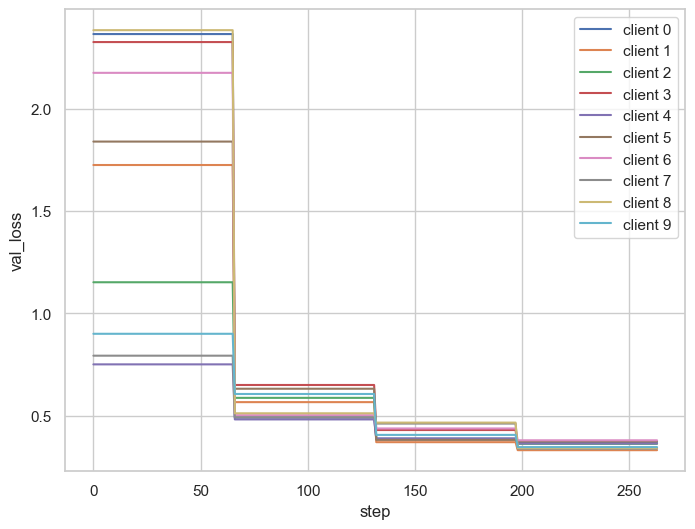

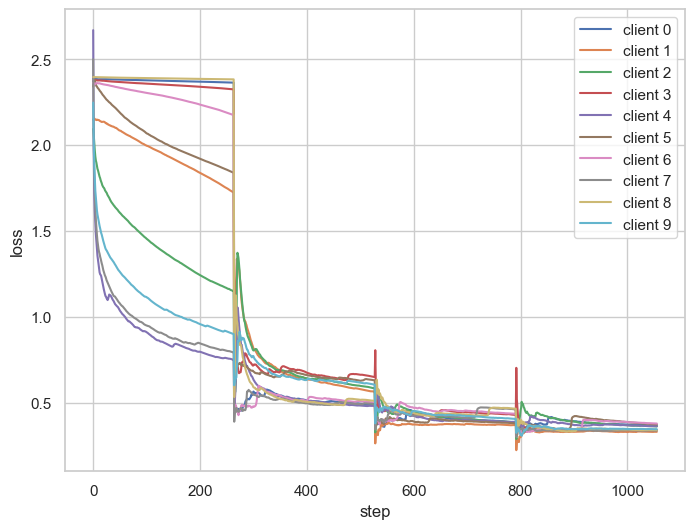

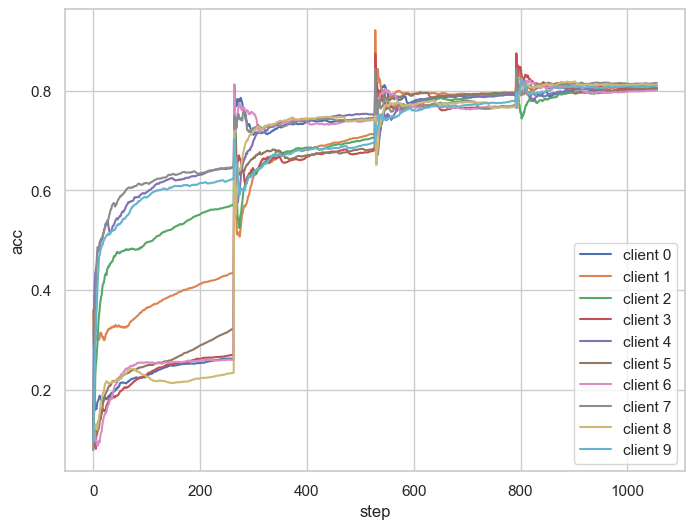

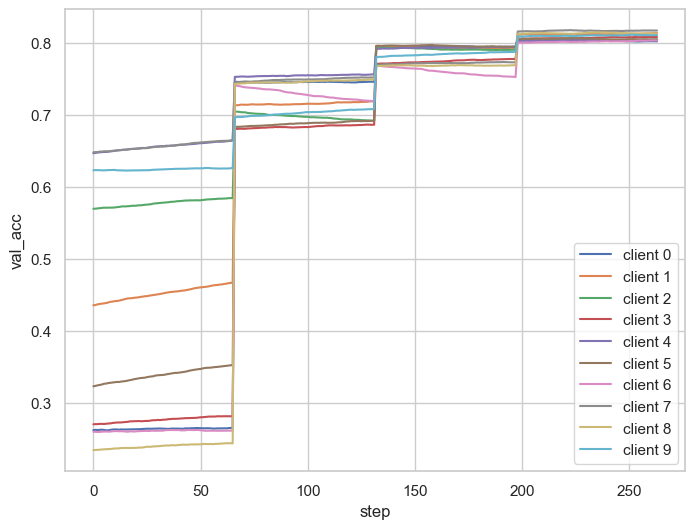

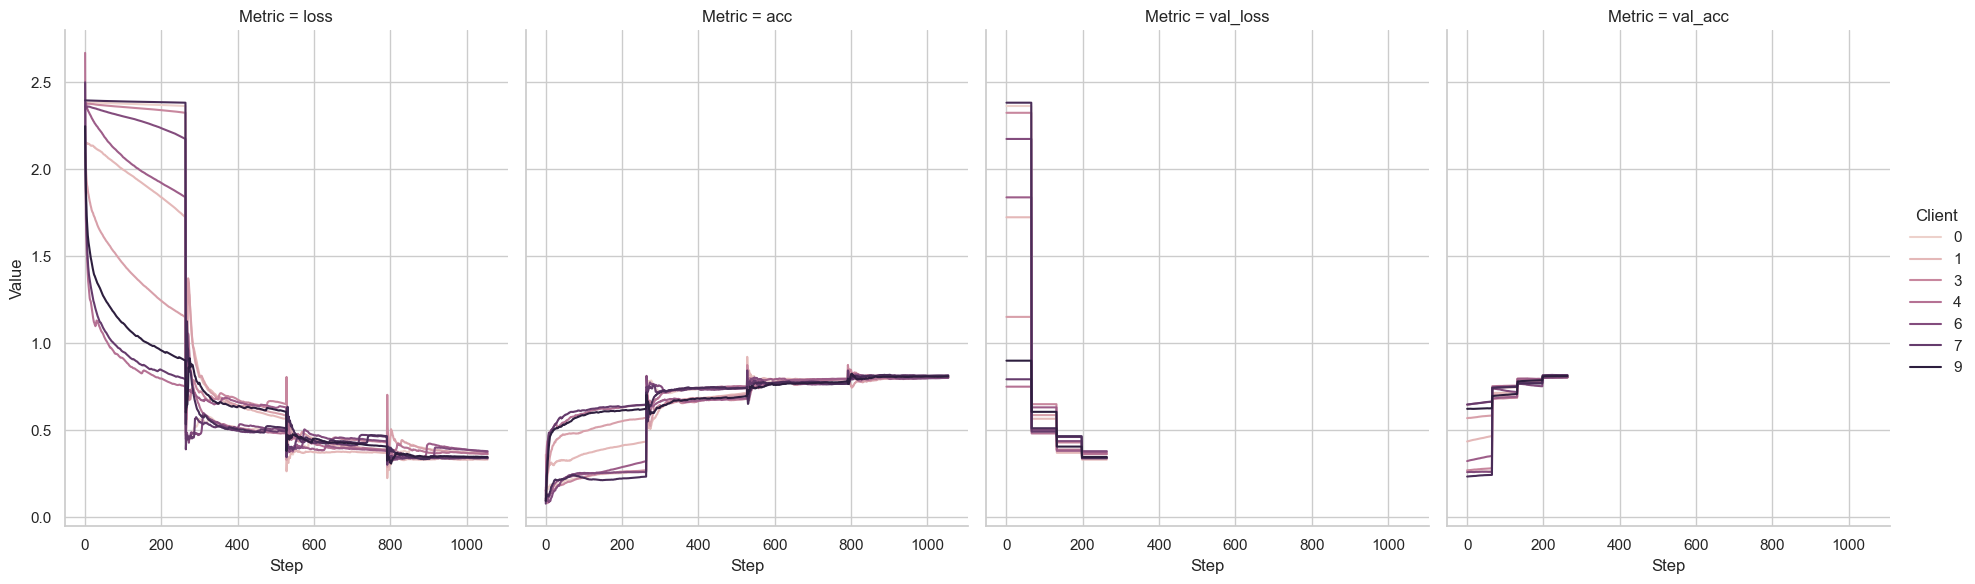

In [89]:
experiment(exp_name='alpha_0p1', cut_layer='dense5')

In [90]:
model1 = load_model('model11.h5')
model1 = compile_model(model1)
loss,acc=model1.evaluate(test_dataset)
print(f" Global Testing Performance: {acc=}, {loss=}")

83/83 [==============================] - 0s 2ms/step - loss: 0.3036 - acc: 0.8256
 Global Testing Performance: acc=0.8255681991577148, loss=0.3036486804485321


In [110]:
pred1 = model1.predict(x_test)

1650/1650 [==============================] - 1s 874us/step


In [111]:
pred1 = np.argmax(pred1,axis=1)

In [112]:
pred1

array([6, 8, 8, ..., 2, 3, 9], dtype=int64)

In [113]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

<AxesSubplot:>

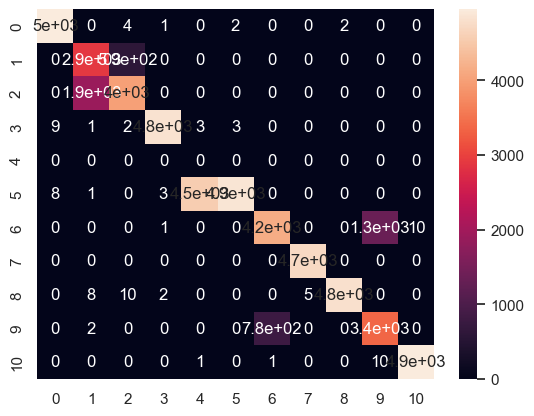

In [165]:
cm=confusion_matrix(pred1,y_test)
import matplotlib.pyplot as plt
sns.heatmap(cm,annot=True)

In [175]:
print(classification_report(pred1,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4964
           1       0.60      0.83      0.70      3495
           2       0.87      0.68      0.76      5902
           3       1.00      1.00      1.00      4840
           4       0.00      0.00      0.00         0
           5       1.00      0.52      0.68      9431
           6       0.84      0.76      0.80      5508
           7       1.00      1.00      1.00      4709
           8       1.00      0.99      1.00      4841
           9       0.71      0.81      0.76      4152
          10       1.00      1.00      1.00      4958

    accuracy                           0.82     52800
   macro avg       0.82      0.78      0.79     52800
weighted avg       0.92      0.82      0.86     52800



C:\Users\yashw\FLnew\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yashw\FLnew\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yashw\FLnew\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [115]:
y_test

array([9, 8, 8, ..., 2, 3, 9])

In [116]:
accuracy_score(pred1,y_test)

0.8246401515151515

In [117]:
df = pd.DataFrame({'True': y_test, 'Predicted': pred1})

In [118]:
df.head(10)

,True,Predicted
0,9,6
1,8,8
2,8,8
3,6,6
4,8,8
5,2,2
6,9,6
7,7,7
8,4,5
9,7,7


In [98]:
model2 = load_model('model21.h5')
model2 = compile_model(model2)
loss,acc=model2.evaluate(test_dataset)
print(f" Global Testing Performance: {acc=}, {loss=}")

83/83 [==============================] - 0s 1ms/step - loss: 2.7240 - acc: 0.6061
 Global Testing Performance: acc=0.6060606241226196, loss=2.7239692211151123


In [99]:
pred2= model2.predict(x_test)
pred2 = np.argmax(pred2,axis=1)
accuracy_score(pred2,y_test)

1650/1650 [==============================] - 2s 977us/step


0.6114962121212121

In [122]:
df1 = pd.DataFrame({'True': y_test, 'Predicted': pred2})
df1.head(10)

,True,Predicted
0,9,6
1,8,8
2,8,8
3,6,6
4,8,8
5,2,1
6,9,6
7,7,8
8,4,5
9,7,8


In [100]:
model3 = load_model('model31.h5')
model3 = compile_model(model3)
loss,acc=model3.evaluate(test_dataset)
print(f" Global Testing Performance: {acc=}, {loss=}")

83/83 [==============================] - 0s 1ms/step - loss: 1.1765 - acc: 0.5750
 Global Testing Performance: acc=0.574999988079071, loss=1.1765369176864624


In [138]:
pred3= model3.predict(x_test)
pred3 = np.argmax(pred3,axis=1)
accuracy_score(pred3,y_test)

1650/1650 [==============================] - 2s 926us/step


0.5726136363636364

In [123]:
df2 = pd.DataFrame({'True': y_test, 'Predicted': pred3})
df2.head(10)

,True,Predicted
0,9,10
1,8,8
2,8,8
3,6,6
4,8,8
5,2,2
6,9,0
7,7,7
8,4,5
9,7,7


In [128]:
import statistics
from statistics import mode,mean

In [133]:
final_pred = np.array([])
for i in range(0,len(x_test)):
    final_pred = np.append(final_pred, mode([pred1[i], pred2[i], pred3[i]]))

In [134]:
final_pred[0]

6.0

In [135]:
finalpred = pd.DataFrame({'True': y_test, 'Predicted': final_pred})
finalpred.head(10)

,True,Predicted
0,9,6.0
1,8,8.0
2,8,8.0
3,6,6.0
4,8,8.0
5,2,2.0
6,9,6.0
7,7,7.0
8,4,5.0
9,7,7.0


In [136]:
accuracy_score(final_pred,y_test)

0.8003787878787879

In [166]:
p = model2.predict(test_dataset)
    

83/83 [==============================] - 0s 2ms/step


In [167]:
p=[]
for data, labels in test_dataset:
    pr=model2.predict(data)
    p.append(pr)
    

1/1 [==============================] - 0s 16ms/step


In [168]:
pc=[]
for i in p:
    pp = np.argmax(i,axis=1)
    pc.append(pp)

In [169]:
pc=np.concatenate(pc)
pc

array([5, 5, 5, ..., 2, 5, 6], dtype=int64)

In [170]:
ac=[]
for data,labels in test_dataset:
    labels=labels.numpy()
    ac.append(labels)

In [171]:
ac = np.concatenate(ac)
ac

array([5, 5, 4, ..., 1, 4, 9])

In [172]:
accuracy_score(pc,ac)

0.6060606060606061

In [173]:
fd = pd.DataFrame({'True': ac, 'Predicted': pc})
fd.head(10)

,True,Predicted
0,5,5
1,5,5
2,4,5
3,3,3
4,4,5
5,1,1
6,9,6
7,10,10
8,1,2
9,8,1


In [187]:
TrainHistory

dict[str, dict[str, list]]